In [1]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

from sklearn.datasets.samples_generator import make_circles
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# 用Seaborn画图 
import seaborn as sns
sns.set()

## 5.7 支持向量机
`支持向量机`(support vector machine，SVM)是非常强大、灵活的有监督学习算法，既可用于分类，也可用于回归。

### 5.7.1 支持向量机的由来
前面介绍贝叶斯分类器时，我们首先对每个类进行了随机分布的假设，然后用生成的模型估计新数据点的标签，这是`生成分类方法`。这里将介绍`判别分类方法`：不再为每类数据建模，而是用一条分割线(二维空间中的直线或曲线)或者流形体(多维空间中的曲线、曲面等概念的推广)将各种类型分割开。

下面的分类示例中两种类型的数据可以被清晰地分割开(`图5-53`)：

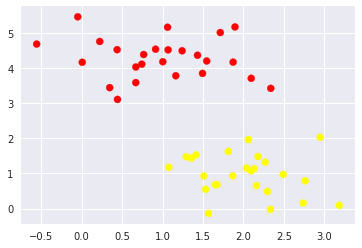

In [2]:
X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.show()

线性判别分类器尝试画一条将数据分成两部分的直线，这样就构成了一个分类模型。对于上图的二维数据来说，这个任务其实可以手动完成。但是我们马上发现一个问题：在这两种类型之间，有不止一条直线可以将它们完美分割。

我们把它们画出来看看(`图5-54`)：

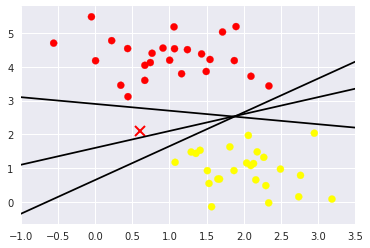

In [3]:
xfit = np.linspace(-1, 3.5)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn') 
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5)
plt.show()

这三个分割器都能完美地判别这些样本，但是选择不同的分割线，可能会让新的数据点(`图5-54`的`X`点)分配到不同的标签。显然，“画一条分割不同类型的直线”还不够，我们需要进一步思考。

### 5.7.2  支持向量机：边界最大化
支持向量机提供了改进这个问题的方法，它直观的解释是：不再画一条细线来区分类型，而是画一条到最近点`边界`、有宽度的线条(`图5-55`)：

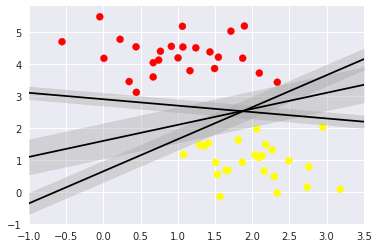

In [4]:
xfit = np.linspace(-1, 3.5) 

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b 
    plt.plot(xfit, yfit, '-k') 
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5)
plt.show()

***在支持向量机中，选择边界最大的那条线是模型最优解。支持向量机其实就是一个边界最大化评估器***。

#### 5.7.2.1 拟合支持向量机
来看看这个数据的真实拟合结果：用`Scikit-Learn`的支持向量机分类器在数据上训练一个SVM模型。这里用一个线性核函数，并将参数`C`设置为一个很大的数：

In [5]:
model = SVC(kernel='linear', C=1E10) 
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

画出SVM的决策边界(`图5-56`)：

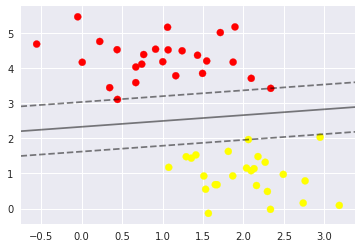

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True): 
    """画二维SVC的决策函数""" 
    if ax is None:
        ax = plt.gca() 
    
    xlim = ax.get_xlim() 
    ylim = ax.get_ylim()

    # 创建评估模型的网格 
    x = np.linspace(xlim[0], xlim[1], 30) 
    y = np.linspace(ylim[0], ylim[1], 30) 
    Y, X = np.meshgrid(y, x) 
    xy = np.vstack([X.ravel(), Y.ravel()]).T 
    P = model.decision_function(xy).reshape(X.shape)

    # 画决策边界和边界 
    ax.contour(X, Y, P, colors='k', 
               levels=[-1, 0, 1], alpha=0.5, 
               linestyles=['--', '-', '--'])
    
    # 画支持向量 
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0], 
                   model.support_vectors_[:, 1], 
                   s=300, linewidth=1, facecolors='none')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn') 
plot_svc_decision_function(model)
plt.show()

这就是两类数据间隔最大的分割线。有一些点正好就在边界线上，这些点是拟合的关键支持点，被称为`支持向量`，支持向量机算法也因此得名。在`Scikit-Learn`里面，支持向量的坐标存放在分类器的`support_vectors_`属性中：

In [7]:
model.support_vectors_

array([[ 0.44359863,  3.11530945],
       [ 2.33812285,  3.43116792],
       [ 2.06156753,  1.96918596]])

分类器能够成功拟合的关键因素，就是这些支持向量的位置，远离边界线的点都不会影响拟合结果！从技术角度解释的话，是因为这些点不会对拟合模型的损失函数产生任何影响，所以只要它们没有跨越边界线，它们的位置和数量就都无关紧要。

可以分别画出数据集前60个点和前120个点的拟合结果，并进行对比(`图5-57`)：

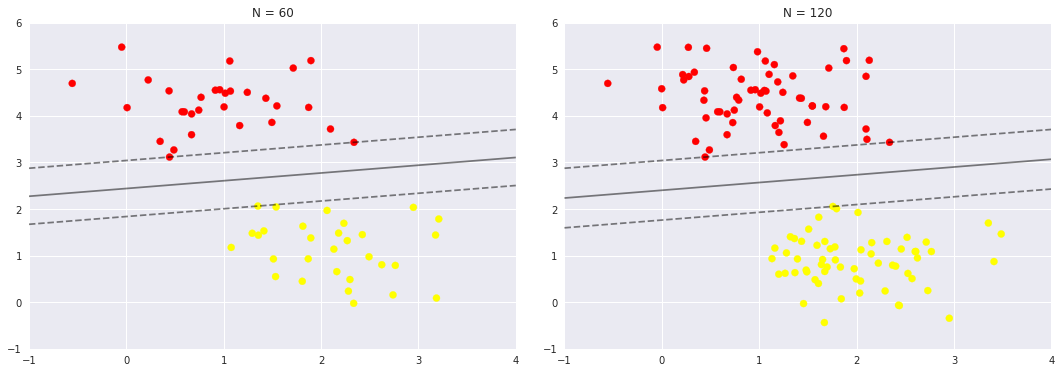

In [8]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=N, centers=2, random_state=0, cluster_std=0.60) 
    X = X[:N] 
    y = y[:N] 
    
    model = SVC(kernel='linear', C=1E10) 
    model.fit(X, y)

    ax = ax or plt.gca() 
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn') 
    ax.set_xlim(-1, 4) 
    ax.set_ylim(-1, 6) 
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6)) 
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1) 
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi) 
    axi.set_title('N = {0}'.format(N))

plt.show()

虽然两个模型训练数据点的个数不同，但是模型并没有改变：左图中的3个支持向量仍然适用于右图。**对远离边界的数据点不敏感的特点正是SVM模型的优点之一**。

#### 5.7.2.2 超越线性边界：核函数SVM模型
将SVM模型与核函数组合使用，功能会非常强大。`5.6`节介绍过一些核函数，我们将数据投影到多项式和高斯基函数定义的高维空间中，从而实现用线性分类器拟合非线性关系。在SVM模型中可以沿用同样的思路。

为了应用核函数，引入一些非线性可分的数据(`图5-59`)：

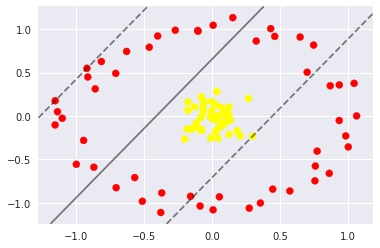

In [9]:
X, y = make_circles(100, factor=.1, noise=.1) 

clf = SVC(kernel='linear').fit(X, y) 

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn') 
plot_svc_decision_function(clf, plot_support=False)
plt.show()

显然，这里需要用非线性判别方法来分割数据。回顾一下`5.6`节介绍的基函数回归方法，想想如何将数据投影到高维空间，从而使线性分割器可以派上用场。例如，一种简单的投影方法就是计算一个以数据圆圈(middle clump)为中心的`径向基函数`：

In [10]:
# 代码错误！！
from ipywidgets import interact, fixed
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y))

NameError: name 'r' is not defined

<function __main__.plot_3D>

增加新维度之后，数据变成了线性可分状态。如果现在画一个分割平面，例如$r = 0.7$，即可将数据分割。


我们还需要仔细选择和优化投影方式；如果不能将径向基函数集中到正确的位置，那么就得不到如此干净、可分割的结果。通常，选择基函数比较困难，我们需要让模型自动指出最合适的基函数。

一种策略是计算基函数在数据集上每个点的变换结果，让SVM算法从所有结果中筛选出最优解。这种基函数变换方式被称为核变换，是基于每对数据点之间的相似度(或者核函数)计算的。

这种策略的问题是，如果将`N`个数据点投影到`N`维空间，当`N`不断增大的时候就会出现维度灾难，计算量巨大。但由于[核函数技巧](http://bit.ly/2fStZeA)提供的小程序可以隐式计算核变换数据的拟合，也就是说，不需要建立完全的`N`维核函数投影空间！这个核函数技巧内置在SVM模型中，是使SVM方法如此强大的充分条件。

在`Scikit-Learn`里面，我们可以应用核函数化的SVM模型将线性核转变为`RBF`(径向基函数)核(`图5-61`)：

In [11]:
clf = SVC(kernel='rbf', C=1E6) 
clf.fit(X, y)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

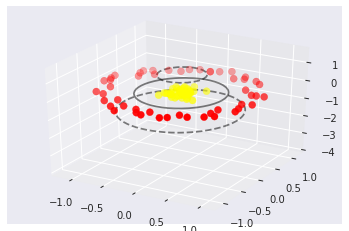

In [12]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf) 
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], 
            s=300, lw=1, facecolors='none')
plt.show()

通过使用这个核函数化的支持向量机，我们找到了一条合适的非线性决策边界。在机器学习中，核变换策略经常用于将快速线性方法变换成快速非线性方法。

#### 5.7.2.3 SVM优化：软化边界 
到目前为止，我们介绍的模型都是在处理非常干净的数据集，里面都有非常完美的决策边界。如果你的数据有一些重叠该怎么办呢？例如有如下一些数据(`图5-62`)：

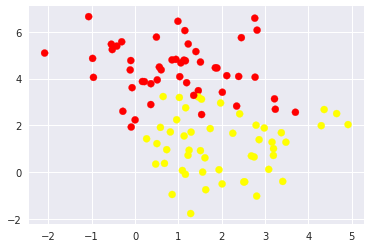

In [13]:
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=1.2) 
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.show()

为了解决这个问题，SVM实现了一些修正因子来`软化`边界。为了取得更好的拟合效果，它允许一些点位于边界线之内。边界线的硬度可以通过超参数进行控制，通常是`C`。如果`C`很大，边界就会很硬，数据点便不能在边界内`生存`；如果`C`比较小，边界线比较软，有一些数据点就可以穿越边界线如`图5-63`：

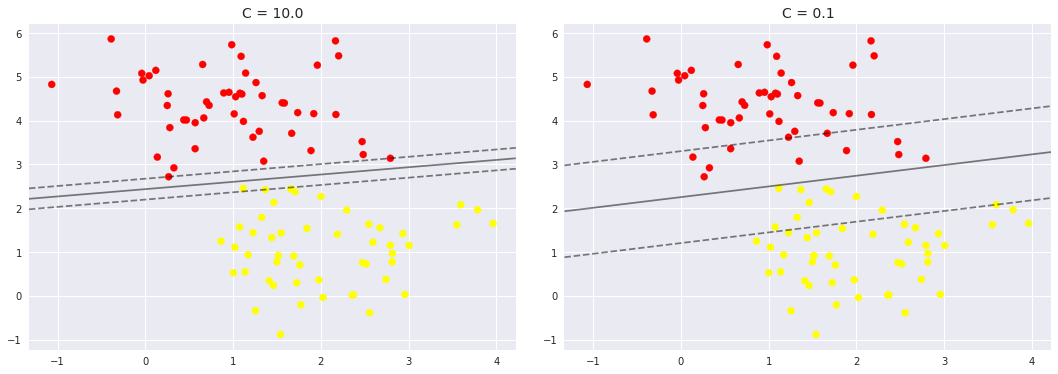

In [14]:
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

plt.show()

参数`C`的最优值视数据集的具体情况而定，通过交叉检验程序进行计算。

### 5.7.3 案例：人脸识别
我们用人脸识别案例来演示支持向量机的实战过程：

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


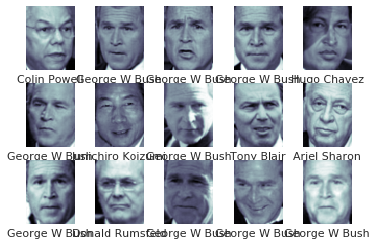

In [15]:
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

fig, ax = plt.subplots(3, 5)

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone') 
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])
plt.show()

每个图像包含`[62×47]`像素。虽然可以将每个像素作为一个特征，但是更高效的方法通常是使用预处理器来提取更有意义的特征。这里使用`主成分分析`来提取`150`个基本元素作为特征：

In [16]:
pca = PCA(svd_solver='randomized', n_components=150, whiten=True, random_state=42) 
svc = SVC(kernel='rbf', class_weight='balanced') 
model = make_pipeline(pca, svc)

Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

param_grid = {'svc__C': [1, 5, 10, 50], 
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]} 

grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain) 
print(grid.best_params_)

CPU times: user 31.5 s, sys: 13.8 s, total: 45.2 s
Wall time: 25 s
{'svc__C': 10, 'svc__gamma': 0.001}


**最优参数最终落在了网格的中间位置。如果它们落在了边缘位置，我们可能就需要扩展网格搜索范围，确保最优参数可以被搜索到**。

有了交叉检验的模型，现在就可以对测试集的数据进行预测了：

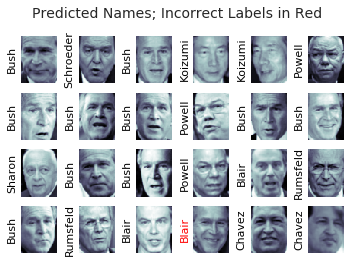

In [17]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)

plt.show()

在这个小样本中，我们的最优评估器只判断错了一张照片。我们可以打印分类效果报告，它会列举每个标签的统计结果，从而对评估器的性能有更全面的认识：

In [18]:
print(classification_report(ytest, yfit, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

      avg / total       0.86      0.85      0.85       337



可以画出这些标签的混淆矩阵(`图5-66`)：

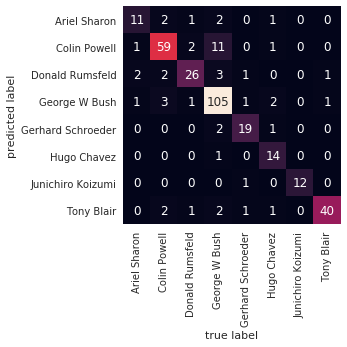

In [19]:
mat = confusion_matrix(ytest, yfit) 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=faces.target_names, yticklabels=faces.target_names) 
plt.xlabel('true label') 
plt.ylabel('predicted label')
plt.show()

这幅图可以帮助我们清晰地判断哪些标签容易被分类器误判。

真实环境中的人脸识别问题的照片通常不会被切割得这么整齐，两类人脸分类机制的唯一差别其实是特征选择：你需要用更复杂的算法找到人脸，然后提取图片 中与像素化无关的人脸特征。这类问题有一个不错的解决方案，就是用OpenCV配合其他手段，包括最先进的通用图像和人脸图像的特征提取工具，来获取人脸特征数据。

### 5.7.4 支持向量机总结
支持向量机是一种强大的分类方法，主要有四点理由：
+ 模型依赖的支持向量比较少，说明它们都是非常精致的模型，消耗内存少
+ 一旦模型训练完成，预测阶段的速度非常快
+ 由于模型只受边界线附近的点的影响，因此它们对于高维数据的学习效果非常好，即使训练比样本维度还高的数据也没有问题，而这是其他算法难以企及的
+ 与核函数方法的配合极具通用性，能够适用不同类型的数据

SVM模型也有一些缺点：
+ 随着样本量`N`的不断增加，最差的训练时间复杂度会达到$\vartheta[N^3]$；经过高效处理后，也只能达到$\vartheta[N^2]$。因此，大样本学习的计算成本会非常高
+ 训练效果非常依赖于边界软化参数`C`的选择是否合理。这需要通过交叉检验自行搜索；当数据集较大时，计算量也非常大
+ 预测结果不能直接进行概率解释。这一点可以通过内部交叉检验进行评估(具体请参见SVC的`probability`参数的定义)，但是评估过程的计算量也很大

由于这些限制条件的存在，我通常只会在其他简单、快速、调优难度小的方法不能满足需求时，才会选择支持向量机。但是，如果你的计算资源足以支撑SVM对数据集的训练和交叉检验，那么用它一定能获得极好的效果。